This notebook is for the plots reproduced from the lecture notes and associated papers. Will fill up with time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob as g
import pandas as pd
from scipy.interpolate import griddata

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('seaborn-v0_8')

In [25]:
file = sorted(g.glob('output_rrtm_MLS-clr*'))
print(file)

finput = sorted(g.glob('input_rrtm_MLS-clr*'))
print(finput)

['output_rrtm_MLS-clr', 'output_rrtm_MLS-clr-CO2', 'output_rrtm_MLS-clr-H2O', 'output_rrtm_MLS-clr-O3', 'output_rrtm_MLS-clr-sw', 'output_rrtm_MLS-clr-sw-CO2', 'output_rrtm_MLS-clr-sw-H2O', 'output_rrtm_MLS-clr-sw-O3']
['input_rrtm_MLS-clr', 'input_rrtm_MLS-clr-CO2', 'input_rrtm_MLS-clr-H2O', 'input_rrtm_MLS-clr-O3', 'input_rrtm_MLS-clr-sw', 'input_rrtm_MLS-clr-sw-CO2', 'input_rrtm_MLS-clr-sw-H2O', 'input_rrtm_MLS-clr-sw-O3']


In [26]:
def rrtmg_lw_input_read(nlev, file):
    temparr = np.empty(0);
    parr = np.empty(0);
    tave = np.empty(0);
    pave = np.empty(0);
    mix_ratio = np.array([[0.0 for x in range(8)]for y in range(51)]);
    
    fi = open(file, 'r')
    lines = fi.readlines()[0:]

    line7 = lines[7].split()
    #Updating pressure and temperature for top and bottom of 1st layer separately
    temparr = np.append(temparr, line7[5])
    parr = np.append(parr, line7[4])
    temparr = np.append(temparr, line7[8])
    parr = np.append(parr, line7[7])
    tave = np.append(tave, line7[1]);
    pave = np.append(pave, line7[0]);    

    for j in range(9,nlev,2):
       tmp1 = lines[j];
       tmpave = tmp1.split();
       tave = np.append(tave, tmpave[1]);
       pave = np.append(pave, tmpave[0]);
       indices = [71];
       tmp2 = [tmp1[i:j] for i,j in zip(indices, indices[1:]+[None])];
       tmp3 = np.empty([0,0])
       for val in tmp2:
        tmp3 = np.append(tmp3, val.split())
       temparr = np.append(temparr, tmp3[1])
       parr = np.append(parr, tmp3[0])

    for j in range(8, nlev, 2):
       tmp1 = lines[j]
       tmp2 = tmp1.split()
       for u in range(0,len(tmp2)):
           tmp2[u] = float(tmp2[u])
       # print(tmp2)
       for k in range(0,len(tmp2)):
         mix_ratio[(j-8)//2][k] = tmp2[k]
        
    temparr = [float(val) for val in temparr]
    parr = [float(value) for value in parr]
    tave = [float(val) for val in tave]
    pave = [float(value) for value in pave]    
    fi.close()

    return temparr, parr, tave, pave, mix_ratio

In [27]:
def rrtmg_sw_input_read(nlev, file):
    temparr = np.empty(0);
    parr = np.empty(0);
    tave = np.empty(0);
    pave = np.empty(0);
    mix_ratio = np.array([[0.0 for x in range(8)]for y in range(51)]);
    
    fi = open(file, 'r')
    lines = fi.readlines()[0:]

    line8 = lines[8].split()
    #Updating pressure and temperature for top and bottom of 1st layer separately
    temparr = np.append(temparr, line8[5])
    parr = np.append(parr, line8[4])
    temparr = np.append(temparr, line8[8])
    parr = np.append(parr, line8[7])
    tave = np.append(tave, line8[1]);
    pave = np.append(pave, line8[0]);    

    for j in range(10,nlev,2):
       tmp1 = lines[j];
       tmpave = tmp1.split();
       tave = np.append(tave, tmpave[1]);
       pave = np.append(pave, tmpave[0]);
       indices = [71];
       tmp2 = [tmp1[i:j] for i,j in zip(indices, indices[1:]+[None])];
       tmp3 = np.empty([0,0])
       for val in tmp2:
        tmp3 = np.append(tmp3, val.split())
       temparr = np.append(temparr, tmp3[1])
       parr = np.append(parr, tmp3[0])

    for j in range(9, nlev, 2):
       tmp1 = lines[j]
       tmp2 = tmp1.split()
       for u in range(0,len(tmp2)):
           tmp2[u] = float(tmp2[u])
       # print(tmp2)
       for k in range(0,len(tmp2)):
         mix_ratio[(j-8)//2][k] = tmp2[k]
        
    temparr = [float(val) for val in temparr]
    parr = [float(value) for value in parr]
    tave = [float(val) for val in tave]
    pave = [float(value) for value in pave]    
    fi.close()

    return temparr, parr, tave, pave, mix_ratio

In [28]:
def rrtmg_lw_output_read(nlev, file, string):
    lvl = np.full(nlev,np.nan);
    prs = np.full(nlev,np.nan);
    fup = np.full(nlev,np.nan);
    fdn = np.full(nlev,np.nan);
    fnt = np.full(nlev,np.nan);
    htr = np.full(nlev,np.nan);
    
    fi  = open(file,'r')
    lines = fi.readlines()[0:]
    for row in lines:
        # check if string present on a current line
        word = string
        # if found it returns index of the first occurrence of the substring
        if row.find(word) != -1:
            #print('string exists in file')
            index = lines.index(row)
            #print(index)
            lines = lines[index+3:]
            break
    
    #print(lines)
    

    for j in range(0,nlev):

        tmp1 = lines[j];
        tmp2 = tmp1.split();
        lvl[j] = tmp2[0];
        prs[j] = tmp2[1];
        fup[j] = tmp2[2];
        fdn[j] = tmp2[3];
        fnt[j] = tmp2[4];
        htr[j] = tmp2[5]; 
        
    lvl = lvl[::-1]
    prs = prs[::-1]
    fup = fup[::-1]
    fdn = fdn[::-1]
    fnt = fnt[::-1]
    htr = htr[::-1]
    
    fi.close()
    return lvl,prs,fnt,htr,string,fup,fdn

In [29]:
def rrtmg_sw_output_read(nlev, file, string):
    lvl = np.full(nlev,np.nan);
    prs = np.full(nlev,np.nan);
    fup = np.full(nlev,np.nan);
    fdn = np.full(nlev,np.nan);
    fnt = np.full(nlev,np.nan);
    htr = np.full(nlev,np.nan);
    
    fi  = open(file,'r')
    lines = fi.readlines()[0:]
    for row in lines:
        # check if string present on a current line
        word = string
        # if found it returns index of the first occurrence of the substring
        if row.find(word) != -1:
            #print('string exists in file')
            index = lines.index(row)
            #print(index)
            lines = lines[index+3:]
            break
    
    #print(lines)

    for j in range(0,nlev):

        tmp1 = lines[j];
        tmp2 = tmp1.split();
        lvl[j] = tmp2[0];
        prs[j] = tmp2[1];
        fup[j] = tmp2[2];
        fdn[j] = tmp2[5];
        fnt[j] = tmp2[6];
        htr[j] = tmp2[7]; 
        
    lvl = lvl[::-1]
    prs = prs[::-1]
    fup = fup[::-1]
    fdn = fdn[::-1]
    fnt = fnt[::-1]
    htr = htr[::-1]
    
    fi.close()
    return lvl,prs,fnt,htr,string,fup,fdn


Define an array for all strings:

bands = np.array(['10.0 -  350.0', '350.0 -  500.0', '500.0 -  630.0', '630.0 -  700.0', '700.0 -  820.0','820.0 -  980.0', '980.0 - 1080.0', '1080.0 - 1180.0', '1180.0 - 1390.0', '1390.0 - 1480.0', '1480.0 - 1800.0',  '1800.0 - 2080.0', '2080.0 - 2250.0', '2250.0 - 2380.0', '2380.0 - 2600.0', '2600.0 - 3250.0'])

In [30]:
def return_bands():
    bands = np.array(['10.0 -  350.0', '350.0 -  500.0', '500.0 -  630.0', '630.0 -  700.0', '700.0 -  820.0','820.0 -  980.0', '980.0 - 1080.0', '1080.0 - 1180.0', '1180.0 - 1390.0', '1390.0 - 1480.0', '1480.0 - 1800.0',  '1800.0 - 2080.0', '2080.0 - 2250.0', '2250.0 - 2380.0', '2380.0 - 2600.0', '2600.0 - 3250.0', '10.0 - 3250.0'])
    return bands

Define an array for all strings:

bands = np.array(['820. -  2600.', '2600. -  3250.', '3250. -  4000.', '4000. -  4650.', '4650. -  5150.','5150. -  6150.', '6150. -  7700.', '7700. -  8050.', '8050. - 12850.', '12850. - 16000.', '16000. - 22650.',  '22650. - 29000.', '29000. - 38000.', '38000. - 50000.', '820. - 50000.'])

In [31]:
def return_bands_sw():
    bands = np.array(['820. -  2600.', '2600. -  3250.', '3250. -  4000.', '4000. -  4650.', '4650. -  5150.','5150. -  6150.', '6150. -  7700.', '7700. -  8050.', '8050. - 12850.', '12850. - 16000.', '16000. - 22650.',  '22650. - 29000.', '29000. - 38000.', '38000. - 50000.', '820. - 50000.'])
    return bands

In [32]:
input_mls = rrtmg_lw_input_read(109, finput[0])
output_51l = rrtmg_lw_output_read(51,file[0],return_bands()[16]) #Midlattitude summer sky, clear conditions, 51 layers

In [33]:
input_mls_sw = rrtmg_sw_input_read(110, finput[4])
output_mls_sw = rrtmg_sw_output_read(51,file[4],return_bands_sw()[14]) #Midlattitude summer sky, clear conditions, 51 layers

In [34]:
bandfull = return_bands()[:-1]
bandfull = [p.split() for p in bandfull]
bands = [(float(p[2])+float(p[0]))/2 for p in bandfull] #Interpolating across average values
widths = [(float(p[2])-float(p[0])) for p in bandfull] #bandwidth
# bands = [float(p[0]) for p in bandfull]
print(bandfull)
print(bands)
print(widths)

htr = np.empty(0)
prs = np.empty(0)
for i in range(16):
    output = rrtmg_lw_output_read(51,file[0],return_bands()[i])
    htr = np.concatenate((htr, output[3][:-2]/widths[i])) #Averaging over bandwidths
    prs = np.concatenate((prs, output[1][:-2]))
bandarr = [np.repeat(bands[i], 49) for i in range(16)]
bandarr = np.concatenate(bandarr).ravel()
# htr = [p-min(htr) for p in htr]
htr = [-p for p in htr]

df = pd.DataFrame({'x':bandarr, 'y':prs, 'z':htr})
print(min(df.z))
print(max(df.z))

[['10.0', '-', '350.0'], ['350.0', '-', '500.0'], ['500.0', '-', '630.0'], ['630.0', '-', '700.0'], ['700.0', '-', '820.0'], ['820.0', '-', '980.0'], ['980.0', '-', '1080.0'], ['1080.0', '-', '1180.0'], ['1180.0', '-', '1390.0'], ['1390.0', '-', '1480.0'], ['1480.0', '-', '1800.0'], ['1800.0', '-', '2080.0'], ['2080.0', '-', '2250.0'], ['2250.0', '-', '2380.0'], ['2380.0', '-', '2600.0'], ['2600.0', '-', '3250.0']]
[180.0, 425.0, 565.0, 665.0, 760.0, 900.0, 1030.0, 1130.0, 1285.0, 1435.0, 1640.0, 1940.0, 2165.0, 2315.0, 2490.0, 2925.0]
[340.0, 150.0, 130.0, 70.0, 120.0, 160.0, 100.0, 100.0, 210.0, 90.0, 320.0, 280.0, 170.0, 130.0, 220.0, 650.0]
-0.0026669
0.09386871428571428


[-0.0026669  -0.00225018 -0.00183345 -0.00141672 -0.001       0.001
  0.01426696  0.02753392  0.04080088  0.05406784  0.0673348   0.08060176
  0.09386871]


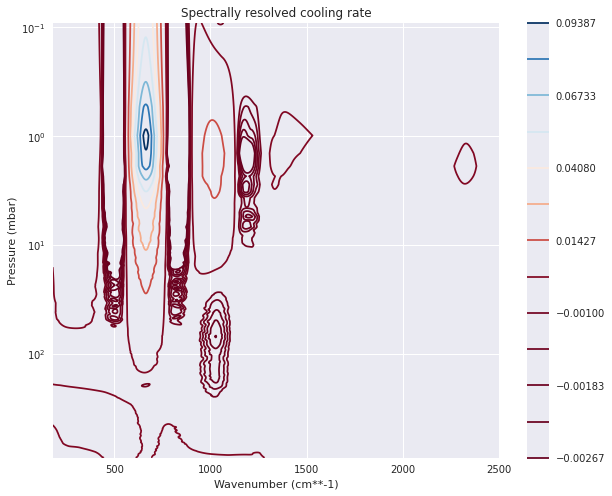

In [35]:
nx = 2000
ny = 2000
vmin = min(df.z)
vmax = max(df.z)
xi = np.linspace(min(df.x), max(df.x), nx)
yi = np.linspace(min(df.y), max(df.y), ny)
x, y = np.meshgrid(xi,yi)
z = griddata((df.x,df.y), df.z, (x,y), method='cubic')

levelarr = np.concatenate((np.linspace(vmin, -0.001, 5), np.linspace(0.001, vmax, 8)), axis=0)
print(levelarr)
fig,ax = plt.subplots(figsize=(10,8))
cs = plt.contour(x,y,z, levels=levelarr, cmap='RdBu')
# plt.clabel(cs, inline=True)
plt.xlabel('Wavenumber (cm**-1)')
plt.xlim(180,2500)
plt.ylabel('Pressure (mbar)')
plt.yscale('log')
plt.ylim(max(df.y),min(df.y))
plt.colorbar()
plt.title('Spectrally resolved cooling rate')
plt.savefig('spectral resolution.pdf', bbox_inches='tight')

[1710.0, 2925.0, 3625.0, 4325.0, 4900.0, 5650.0, 6925.0, 7875.0, 10450.0, 14425.0, 19325.0, 25825.0, 33500.0, 44000.0]
[1780.0, 650.0, 750.0, 650.0, 500.0, 1000.0, 1550.0, 350.0, 4800.0, 3150.0, 6650.0, 6350.0, 9000.0, 12000.0]
0.1
19.0469
686
686
0.1
19.0469


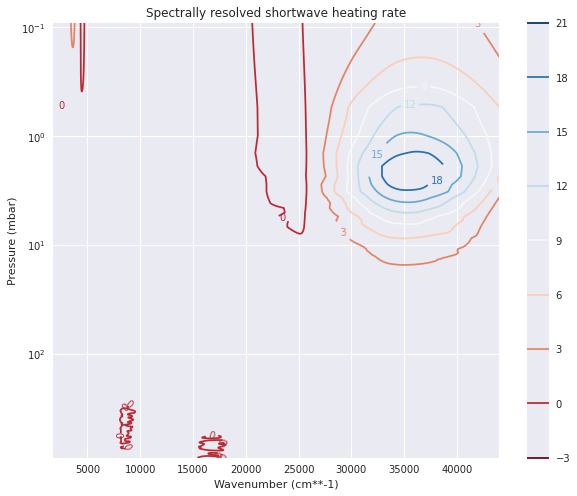

In [36]:
bandfull = return_bands_sw()[:-1]
bandfull = [p.split() for p in bandfull]
bands = [(float(p[2])+float(p[0]))/2 for p in bandfull] #Interpolating across average values
widths = [(float(p[2])-float(p[0])) for p in bandfull] #bandwidth
# bands = [float(p[0]) for p in bandfull]
#print(bandfull)
print(bands)
print(widths)

htr = np.empty(0)
prs = np.empty(0)
for i in range(14):
    output = rrtmg_sw_output_read(51,file[4],return_bands_sw()[i])
    htr = np.concatenate((htr, output[3][:-2])) #Averaging over bandwidths
    prs = np.concatenate((prs, output[1][:-2]))
bandarr = [np.repeat(bands[i], 49) for i in range(14)]
bandarr = np.concatenate(bandarr).ravel()
htr = [p+0.1 for p in htr]
print(min(htr))
print(max(htr))
print(len(prs))
print(len(bandarr))

df = pd.DataFrame({'x':bandarr, 'y':prs, 'z':htr})
print(min(df.z))
print(max(df.z))

nx = 2000
ny = 2000
vmin = min(df.z)
vmax = max(df.z)
xi = np.linspace(min(df.x), max(df.x), nx)
yi = np.linspace(min(df.y), max(df.y), ny)
x, y = np.meshgrid(xi,yi)
z = griddata((df.x,df.y), df.z, (x,y), method='cubic')

# levelarr = np.concatenate((np.linspace(3.0, 6, 5), np.linspace(6, vmax, 3)), axis=0)
# print(levelarr)
fig,ax = plt.subplots(figsize=(10,8))
# cs = plt.contour(x,y,z, levels=levelarr, cmap='RdBu')
cs = plt.contour(x,y,z, cmap='RdBu')
plt.clabel(cs, inline='True')
plt.xlabel('Wavenumber (cm**-1)')
plt.xlim(min(df.x), max(df.x))
plt.ylabel('Pressure (mbar)')
plt.yscale('log')
plt.ylim(max(df.y),min(df.y))
plt.colorbar()
plt.title('Spectrally resolved shortwave heating rate')
plt.savefig('spectral resolution_sw.pdf', bbox_inches='tight')

In [37]:
output_noco2 = rrtmg_lw_output_read(51,file[1],return_bands()[16]) #no CO2
output_noh2o = rrtmg_lw_output_read(51,file[2],return_bands()[16]) #no H2O
output_noo3 = rrtmg_lw_output_read(51,file[3],return_bands()[16]) #no O3
output_noco2_sw = rrtmg_sw_output_read(51,file[5],return_bands_sw()[14]) #no CO2
output_noh2o_sw = rrtmg_sw_output_read(51,file[6],return_bands_sw()[14]) #no H2O
output_noo3_sw = rrtmg_sw_output_read(51,file[7],return_bands_sw()[14]) #no O3

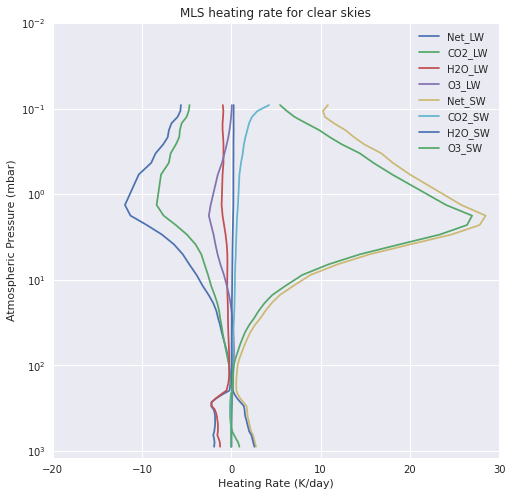

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(output_51l[3][:-2], output_51l[1][:-2], label='Net_LW')
ax.plot(output_51l[3][:-2]-output_noco2[3][:-2], output_51l[1][:-2], label='CO2_LW')
ax.plot(output_51l[3][:-2]-output_noh2o[3][:-2], output_51l[1][:-2], label='H2O_LW')
ax.plot(output_51l[3][:-2]-output_noo3[3][:-2], output_51l[1][:-2], label='O3_LW')
ax.plot(output_mls_sw[3][:-2], output_mls_sw[1][:-2], label='Net_SW')
ax.plot(output_mls_sw[3][:-2]-output_noco2_sw[3][:-2], output_mls_sw[1][:-2], label='CO2_SW')
ax.plot(output_mls_sw[3][:-2]-output_noh2o_sw[3][:-2], output_mls_sw[1][:-2], label='H2O_SW')
ax.plot(output_mls_sw[3][:-2]-output_noo3_sw[3][:-2], output_mls_sw[1][:-2], label='O3_SW')
ax.set_xlabel('Heating Rate (K/day)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_yscale('log')
ax.set_xlim(-20,30)
ax.set_ylim(1200,0.01)
ax.legend()
ax.set_title('MLS heating rate for clear skies')
plt.savefig('threeprofile.pdf' , bbox_inches='tight')

Text(0.5, 1.0, 'MLS heating rate for clear skies')

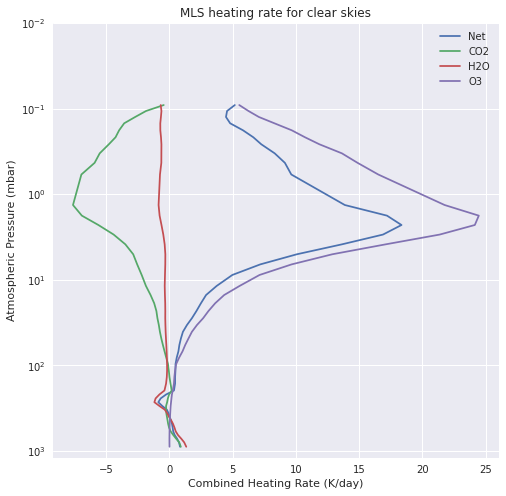

In [113]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(output_51l[3][:-2]+output_mls_sw[3][:-2], output_51l[1][:-2], label='Net')
ax.plot(output_51l[3][:-2]+output_mls_sw[3][:-2]-(output_noco2[3][:-2]+output_noco2_sw[3][:-2]), output_51l[1][:-2], label='CO2')
ax.plot(output_51l[3][:-2]+output_mls_sw[3][:-2]-(output_noh2o[3][:-2]+output_noh2o_sw[3][:-2]), output_51l[1][:-2], label='H2O')
ax.plot(output_51l[3][:-2]+output_mls_sw[3][:-2]-(output_noo3[3][:-2]+output_noo3_sw[3][:-2]), output_51l[1][:-2], label='O3')
ax.set_xlabel('Combined Heating Rate (K/day)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_yscale('log')
ax.set_ylim(1200,0.01)
ax.legend()
ax.set_title('MLS heating rate for clear skies')

In [51]:
def Qclr(net_htr, prs):
    length = len(net_htr)
    c=[]
    for i in range(length):
        if net_htr[i]>0 and net_htr[i-1]<0:
            c.append((prs[i], net_htr[i]))
            # break
    return c

In [52]:
net_htr = output_51l[3][:-2]+output_mls_sw[3][:-2]
print(Qclr(net_htr, output_51l[1]))

[(196.4, 0.37373999999999996)]
